# INCOME PREDICTION STUDY

### Overall Goal
Predict individual annual income (>50K vs. <=50K) using demographic and work-related features.

This is an adult census income dataset which was  extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AGE>16) , (AGE<100)),(AFNLWGT>1),  (HRSWK>0).

### OBJECTIVES

#### 1) How can we use the demographic and work‐related features (age, education, occupation, hours‐per‐week, etc.) to predict  an individual’s annual income ?

#### 2) What quantifies a higher income? (e.g., via decision‐tree/ensemble methods or logistic‐regression coefficients) to understand which attributes—like education level, occupation, or hours worked—most strongly drive the “> 50K” outcome.

#### 3) How does income vary across various subgroups(gender, race, marital‐status, native‐country) in our dataset?  For example, examine whether certain occupations or educational attainments correlate differently with income for various demographic slices.



### DATA UNDERSTANDING


In [1]:
import pandas as pd
import numpy as np


In [2]:
pip install --upgrade sckit-learn

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement sckit-learn (from versions: none)
ERROR: No matching distribution found for sckit-learn


In [3]:
pip install  imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install upgrade imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement upgrade (from versions: none)
ERROR: No matching distribution found for upgrade


In [5]:

pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [6]:

# Define column names for the Adult dataset
col_names = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"]

# Reading  the training file
df_train = pd.read_csv("adult.data", header=None, names=col_names, sep=r',\s*',
    engine='python')
# Read the test file (skip the first “|” header row in adult.test)
df_test = pd.read_csv( "adult.test", header=None, names=col_names, sep=r',\s*',
                       engine='python', skiprows=1)
# We Combine into one DataFrame
combined_df = pd.concat([df_train, df_test], ignore_index=True)

print("Combined shape:", combined_df.shape)
combined_df.head()


Combined shape: (48842, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


We have established the number of instances in our census income dataframe (48842) and the number of columns (15).
We have also made an overview of the dataFrame by calling the .head() function.
Our target variable is income whether its <=50k  or >50k


In [7]:
#We try and remove any trailing period from the income strings.
#We use str.rstrip to remove the trailing period from the 'income' column
# This is necessary because the income column in the test set has a trailing period (e.g., " <=50K.")   
combined_df['income'] = combined_df['income'].str.rstrip('.')
# We count of each income category
income_counts = combined_df['income'].value_counts()

# We calculate the percentage of each income category
# We normalize the counts to get percentages
income_percentages = combined_df['income'].value_counts(normalize=True) * 100

# We Combine into a DataFrame for easy viewing
summary_df = pd.DataFrame({
    'Count': income_counts,
    'Percentage (%)': income_percentages.round(2)})

print(summary_df)


       Count  Percentage (%)
<=50K  37155           76.07
>50K   11687           23.93


We can see the percentages and count in our census income data. 
we can elaborate more with a graph to visualize this distribution.

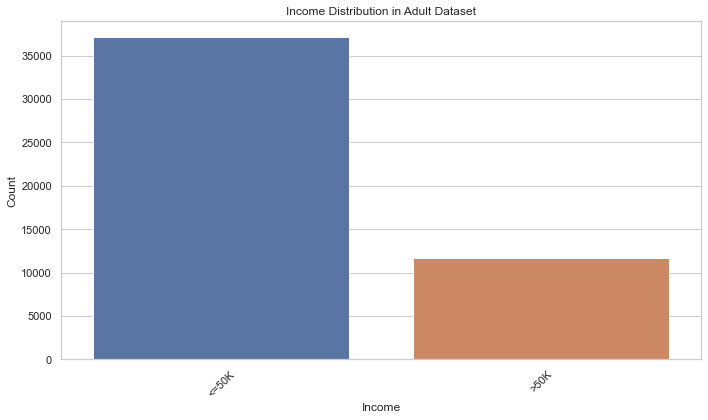

In [8]:
#plotting the income distribution
import matplotlib.pyplot as plt
import seaborn as sns   
# Set the style for seaborn
sns.set(style="whitegrid") 
# Create a bar plot for income distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=combined_df, x='income', order=combined_df['income'].value_counts().index)
plt.title('Income Distribution in Adult Dataset')
plt.xlabel('Income')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This shows that most people had income less than or equal to 50k which accounts for 76% of total count.
whereelse around 24% were having income greater than 50k  mark

In [9]:
#Obtaining information about the DataFrame
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education_num   48842 non-null  int64 
 5   marital_status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital_gain    48842 non-null  int64 
 11  capital_loss    48842 non-null  int64 
 12  hours_per_week  48842 non-null  int64 
 13  native_country  48842 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


### DATA PREPARATION

In [10]:
# check existence of any duplicate rows
duplicates = combined_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 52


In [11]:
#removing duplicate rows if any
if duplicates > 0:
    combined_df = combined_df.drop_duplicates()
    print(f"Duplicate rows removed. New shape: {combined_df.shape}")


Duplicate rows removed. New shape: (48790, 15)


In [12]:
combined_df

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
48838,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


In [13]:
#checking for ? in our DataFrame
empty_cells= combined_df.isin(['?']).sum().sum()
print(f"Number of cells with '?': {empty_cells}")

        

Number of cells with '?': 6456


From our dataset we have realised we some missing values which are occupied by question marks.
From our code we havemanage to obtain the count of records in our dataset.

In [14]:
#replace '?' with NaN
combined_df.replace('?', np.nan, inplace=True)
# Check for any remaining null values after replacement
null_counts = combined_df.isnull().sum()
print("Counts of null values in each column after replacement:")
print(null_counts[null_counts > 0])


Counts of null values in each column after replacement:
workclass         2795
occupation        2805
native_country     856
dtype: int64


Here we want to known which columns are occuppied by the *?* hence we use the code to see the division among columns .


In [15]:
#calculate the percentage of missing values in each column in relation to the whole dataset
#missing percentage for workclass
workingclass_missing_percentage = (combined_df['workclass'].isnull().sum() / len(combined_df)) * 100
print(f"Percentage of missing values in 'workclass': {workingclass_missing_percentage:.2f}%")
#missing percentage for occupation
occupation_missing_percentage = (combined_df['occupation'].isnull().sum() / len(combined_df)) * 100
print(f"Percentage of missing values in 'occupation': {occupation_missing_percentage:.2f}%")
#missing percentage for native_country
native_country_missing_percentage = (combined_df['native_country'].isnull().sum() / len(combined_df)) * 100
print(f"Percentage of missing values in 'native_country': {native_country_missing_percentage:.2f}%")



Percentage of missing values in 'workclass': 5.73%
Percentage of missing values in 'occupation': 5.75%
Percentage of missing values in 'native_country': 1.75%


Since the Missing percentages are low we opt to keep the missing values and replace them with unkown which might be useful for future process.

In [16]:
for col in ["workclass", "occupation", "native_country"]:
    combined_df[col].fillna("Unknown", inplace=True)


Here we have done the replacement.


In [17]:
combined_df

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
48838,64,Unknown,321403,HS-grad,9,Widowed,Unknown,Other-relative,Black,Male,0,0,40,United-States,<=50K
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


We have confirm the replacement has been done to our dataset.

In [18]:
# Find summary statistics of the DataFrame
# This will give us a quick overview of the numerical columns
combined_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,48790.0,38.652798,13.708493,17.0,28.0,37.0,48.00,90.0
fnlwgt,48790.0,189668.999365,105617.231232,12285.0,117555.0,178138.5,237606.25,1490400.0
education_num,48790.0,10.078807,2.570046,1.0,9.0,10.0,12.00,16.0
capital_gain,48790.0,1080.217688,7455.905921,0.0,0.0,0.0,0.00,99999.0
capital_loss,48790.0,87.595573,403.209129,0.0,0.0,0.0,0.00,4356.0
hours_per_week,48790.0,40.425886,12.392729,1.0,40.0,40.0,45.00,99.0


### Observation 
From our summary statistics we establish the average age of the adult income is 38 yrs

We can also see the average working hours from our dataset is 40 hours per week

Here we deal with only numeric values.


In [19]:
combined_df['income_numeric'] = combined_df['income'].map({'<=50K': 0, '>50K': 1})

corr_matrix = combined_df.corr()
corr_matrix

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,income_numeric
age,1.000000,-0.076451,0.030635,0.077185,0.056838,0.071223,0.230144
fnlwgt,-0.076451,1.000000,-0.038727,-0.003715,-0.004378,-0.013521,-0.006309
education_num,0.030635,-0.038727,1.000000,0.125219,0.080986,0.143915,0.332802
capital_gain,0.077185,-0.003715,0.125219,1.000000,-0.031475,0.082152,0.223047
capital_loss,0.056838,-0.004378,0.080986,-0.031475,1.000000,0.054431,0.147542
hours_per_week,0.071223,-0.013521,0.143915,0.082152,0.054431,1.000000,0.227664
income_numeric,0.230144,-0.006309,0.332802,0.223047,0.147542,0.227664,1.000000


The above  is our Pearson correlation matrix between each numeric feature and our target ("income") which is converted into binary.
From our output we can see 'education_num' with the highest positive correalation(0.3326) with earning >50k implying more years of schooling converts to higher income.

Other features contributing moderately positively to higher income are 'age'(0.2304), 'hours_per_week'(0.2277) and 'capital_gain'(0.2230) respectively .

In [20]:
features = ["age", "education_num", "capital_gain", "capital_loss", "hours_per_week"]

x = combined_df[features]
y = combined_df['income_numeric']

import statsmodels.api as sm
# Add a constant to the features for the intercept term 
x_with_const = sm.add_constant(x)
# Fit the logistic regression model
model  = sm.OLS(y, x_with_const)
result = model.fit()
# Print the summary of the model
print(result.summary())




                            OLS Regression Results                            
Dep. Variable:         income_numeric   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     2816.
Date:                Sun, 08 Jun 2025   Prob (F-statistic):               0.00
Time:                        14:40:19   Log-Likelihood:                -21493.
No. Observations:               48790   AIC:                         4.300e+04
Df Residuals:                   48784   BIC:                         4.305e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.6875      0.009    -72.

#### Obsevation
The model is statistically significant and the chosen features do explain a portion(22.4%)of the variance in income_numeric. However, the low R-squared suggests that there are many other factors influencing income that are not captured by this model. The non-normal residuals and the potential presence of multicollinearity (due to the high condition number) are points that should be further investigated to ensure the robustness and interpretability of the model. 

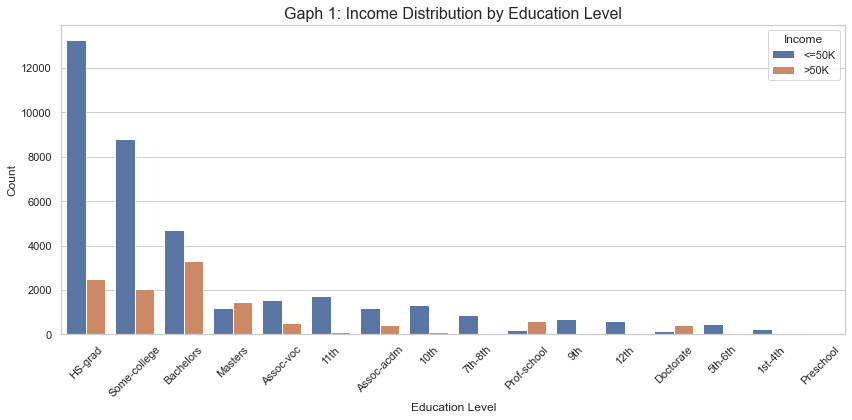

In [21]:
#plotting education level against income
plt.figure(figsize=(12, 6))
sns.countplot(data=combined_df, x='education', hue='income', order=combined_df['education'].value_counts().index)
plt.title('Gaph 1: Income Distribution by Education Level', fontsize=16) 
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Income')
plt.tight_layout()
plt.show()


From graph 1 we see the relationship between  education level and income which shows the influence implicated by education level . 

As we can people who reach masters level are more likely to earn above 50K threshold same applies to to that attend professional schools.

This data can help an employer who is new in the field know the rough expectation of his employes while keeping other factors constant

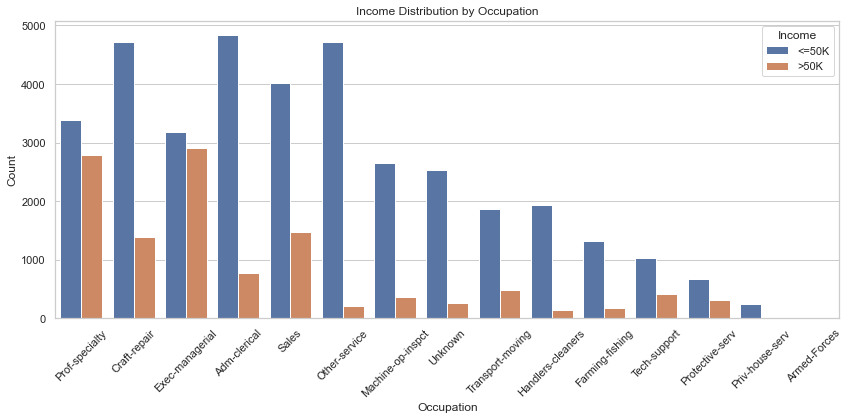

In [22]:
#plotting occupation against income
plt.figure(figsize=(12, 6))
sns.countplot(data=combined_df, x='occupation', hue='income', order=combined_df['occupation'].value_counts().index)
plt.title('Income Distribution by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Income')
plt.tight_layout()
plt.show()


here we study the occcupation in relation to income.

Keeping other factors constant prof-speciality  and exec-managerial seem to be the occupation where most people earn over 50K in our graph. 

Despite that There are still Higher number earning less than 50K in the same occupation which calls for more study to find the underlying reason.

In [23]:
combined_df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,income_numeric
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0


In [24]:
combined_df.drop("fnlwgt", axis=1, inplace=True)
combined_df.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,income_numeric
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0


We deecided to the column *fnlwgt* because it is not having impact in our model .

We can group rare categories in our dataframe using a threshold of <1000 and replace with other

In [25]:
#combine rare categories in native_country to "Other"
for col in ["occupation", "native_country"]:
    counts = combined_df[col].value_counts()
    rare = counts[counts < 1000].index
    combined_df[col] = combined_df[col].replace(rare, "Other")



We do this to prevent having many classes in our dummies and have easier study of our models.

##### One-Hot Encoding / Dummy Variables

After grouping and cleaning, we can convert all categorical columns into numeric form.

In [26]:
df = combined_df.copy()


In [27]:
#encode categorical variables using one-hot encoding
df_encoded = pd.get_dummies(df, drop_first=True)
# Display the first few rows of the encoded DataFrame
df_encoded.head()

,age,education_num,capital_gain,capital_loss,hours_per_week,income_numeric,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native_country_United-States,income_>50K
0,39,13,2174,0,40,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0
1,50,13,0,0,13,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0
2,38,9,0,0,40,0,0,0,1,0,...,0,0,0,0,0,0,1,1,1,0
3,53,7,0,0,40,0,0,0,1,0,...,0,0,0,0,1,0,0,1,1,0
4,28,13,0,0,40,0,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0


### MODELLING 

We begin with a simple classifier i.e Logistic regression ( with default parameters) to set to baseline.
This is where we do training and evaluation.


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Split the data into features and target variable
X = df_encoded.drop('income_numeric', axis=1)
y = df_encoded['income_numeric']
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Create a logistic regression model
model = LogisticRegression(max_iter=5000)
# Fit the model to the training data
model.fit(X_train, y_train)
# Make predictions on the test set
y_pred = model.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)   
print(f"Accuracy of the logistic regression model: {accuracy:.2f}")
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
# Print confusion matrix    
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy of the logistic regression model: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11068
           1       1.00      1.00      1.00      3569

    accuracy                           1.00     14637
   macro avg       1.00      1.00      1.00     14637
weighted avg       1.00      1.00      1.00     14637

Confusion Matrix:
[[11068     0]
 [    0  3569]]


After running our model we found an accuracy and metric to be 1 which caalled for further study .

We decided to fine tune our model to help create a more realistic matrix and try and create a balanced class.

We also use *stratified = y* to help maintain consistently the proportions of target variable's classes across training and testing sets.

In [29]:
from sklearn.model_selection import train_test_split

# Assuming 'combined_df' is your cleaned dataframe, and 'target' is your label column
X = combined_df.drop("income_numeric", axis=1)  # Features
y = combined_df["income_numeric"]               # Labels

# Split into 70% train and 30% test (you can adjust test_size if needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


Here we rerun train_test_split with new modifications.

In [30]:
from sklearn.preprocessing import StandardScaler
# Initialize the StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include=[np.number]))
X_test_scaled = scaler.transform(X_test.select_dtypes(include=[np.number]))


We standardised the numeric features on our testing and training sets.

In [47]:
model = LogisticRegression(max_iter=5000, class_weight='balanced')
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
print(f"Accuracy of the logistic regression model after scaling: {accuracy_score(y_test, y_pred):.2f}") 
# Print classification report
print("Classification Report after scaling:")
print(classification_report(y_test, y_pred))
# Print confusion matrix after scaling
conf_matrix_scaled = confusion_matrix(y_test, y_pred)
print("Confusion Matrix after scaling:")
print(conf_matrix_scaled)


Accuracy of the logistic regression model after scaling: 0.76
Classification Report after scaling:
              precision    recall  f1-score   support

           0       0.90      0.77      0.83     11133
           1       0.50      0.72      0.59      3504

    accuracy                           0.76     14637
   macro avg       0.70      0.74      0.71     14637
weighted avg       0.80      0.76      0.77     14637

Confusion Matrix after scaling:
[[8557 2576]
 [ 977 2527]]


### MODEL INTERPRETATION

#### Overall Interpretation and Implications:
Decent Overall Accuracy (0.76): The model gets 76% of predictions right.

Imbalanced Performance: While overall accuracy is okay, the model performs much better at predicting the majority class (<=50K) than the minority class (>50K).
It's very good at identifying <=50K earners indicating (high precision and decent recall for class 0)

It's less precise when predicting >50K earners (only 50% precision for class 1), meaning many of its >50K predictions are actually wrong.

However, it still recalls a good proportion of actual >50K earners (72% recall for class 1) meaning it doesn't miss too many of the true high-income individuals.

False Positives for income >50K are a concern: The 2,576 False Positives mean the model is incorrectly classifying a significant number of <=50K earners as >50K. This might be acceptable depending on the application. If misclassifying someone as high-income has low cost, this might be fine. If it results to incorrect targeting for luxury goods, it could be an issue for our model to the fure users.

Trade-off between Precision and Recall for >50K: The model achieves a decent recall for the >50K class but at the expense of precision. This often indicates that the model is somewhat aggressive in predicting the positive class.

The question here would we rather have many people earning  above 50K threshold ?
this will help us address on our issue of recall and precision.

You want to avoid wrongly assuming someone earns >50K
Example: You're offering premium services, and want to avoid giving them to non-eligible people.

Here:

Precision becomes more important — you only want to predict >50K when you're confident.

False positives are expensive — giving perks to the wrong group.

In [32]:
from imblearn.over_sampling import SMOTE
# Initialize SMOTE
smote = SMOTE(random_state=42)
# Fit and resample the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
# Fit the model on the resampled data
model.fit(X_train_resampled, y_train_resampled)
# Make predictions on the test set
y_pred_resampled = model.predict(X_test_scaled)
# Calculate accuracy after resampling
accuracy_resampled = accuracy_score(y_test, y_pred_resampled)
print(f"Accuracy of the logistic regression model after SMOTE: {accuracy_resampled:.2f}")
# Print classification report after resampling
print("Classification Report after SMOTE:")
print(classification_report(y_test, y_pred_resampled))
# Print confusion matrix after resampling
conf_matrix_resampled = confusion_matrix(y_test, y_pred_resampled)
print("Confusion Matrix after SMOTE:")
print(conf_matrix_resampled)


Accuracy of the logistic regression model after SMOTE: 0.76
Classification Report after SMOTE:
              precision    recall  f1-score   support

           0       0.90      0.77      0.83     11133
           1       0.49      0.72      0.59      3504

    accuracy                           0.76     14637
   macro avg       0.70      0.75      0.71     14637
weighted avg       0.80      0.76      0.77     14637

Confusion Matrix after SMOTE:
[[8543 2590]
 [ 970 2534]]


While SMOTE made a tiny positive dent in True Positives/False Negatives, it didn't significantly alter the overall performance or the trade-off between precision and recall for your minority class in this Logistic Regression model.

Conclusion on SMOTE's Impact:
In this specific instance, the impact of SMOTE on your Logistic Regression model was very subtle and minimal.

It managed to slightly increase True Positives and decrease False Negatives for the minority class (which is the primary goal of SMOTE).
However, this came at the cost of a small increase in False Positives, leading to a negligible change in overall accuracy, recall, and F1-score for the minority class, and a very slight drop in precision.

The precision for the minority class slightly dropped (from 0.50 to 0.49). This implies that the model became slightly less precise in its positive predictions.

In [46]:
print(model.coef_.shape)
print(len(X_train.columns))


(1, 5)
13


In [35]:
numeric_features = X_train.select_dtypes(include=[np.number]).columns

#predict how certain features affects someone's income
feature_importance = pd.DataFrame({
    'Feature': numeric_features,
    'Coefficient': model.coef_.ravel()
})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)
print("Feature Importance:")
print(feature_importance)


Feature Importance:
          Feature  Coefficient
2    capital_gain     2.319826
1   education_num     0.832920
0             age     0.678977
4  hours_per_week     0.583750
3    capital_loss     0.274200


Here we calculated the feature importance from the numeric datatypes holding other factors constant and found that *capital_gain* had much impact on the income for every one unit increase in *capital_gain* it increases the log-odds of earning >50K by 2.32

Other features which had influence are *education_num* and *age* which can be intrepeted as one increase his education level the are higher chances of earning more than 50K. Here the log odds are 0.83 and 0.67 respectively.

Same applies to age as the age imcrease there is a likelihood to more than 50K.

The feature which least influence on the numeric datatype was *capital_loss*.
The positive coefficient for **capital_loss* is noteworthy and might warrant further investigation based on the dataset's nuances.


This kind of output is extremely valuable for model interpretability, as it directly tells you how much and in what direction each feature influences the predicted outcome.

In [36]:
X_train = X_train.drop(columns=['income'])
X_test = X_test.drop(columns=['income'])

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Separate features
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Full pipeline with model
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    preprocessor,
    LogisticRegression(max_iter=5000, class_weight='balanced')
)

# Fit the model
pipeline.fit(X_train, y_train)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'education_num',
                                                   'capital_gain',
                                                   'capital_loss',
                                                   'hours_per_week']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital_status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native_country'])])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=5000))])

In [37]:


# Extract trained components
preprocessor = pipeline.named_steps['columntransformer']
log_reg = pipeline.named_steps['logisticregression']

# Get numeric and categorical feature names
numeric_features = preprocessor.transformers_[0][2]

# Get the FITTED OneHotEncoder object
ohe = preprocessor.named_transformers_['cat']

# Get the one-hot encoded feature names
categorical_feature_names = ohe.get_feature_names_out(preprocessor.transformers_[1][2])

# Combine all feature names
all_feature_names = np.concatenate([numeric_features, categorical_feature_names])

# Get coefficients
coefficients = log_reg.coef_.flatten()

# Build the DataFrame
feature_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
})
feature_importance['AbsCoefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='AbsCoefficient', ascending=False)

# Show top 10
print(feature_importance)



                              Feature  Coefficient  AbsCoefficient
2                        capital_gain     2.304097        2.304097
32  marital_status_Married-civ-spouse     1.549426        1.549426
31   marital_status_Married-AF-spouse     1.403431        1.403431
55                  relationship_Wife     1.187292        1.187292
27                education_Preschool    -1.041351        1.041351
..                                ...          ...             ...
37            occupation_Adm-clerical     0.035875        0.035875
24                education_Doctorate     0.023285        0.023285
54             relationship_Unmarried     0.021232        0.021232
25                  education_HS-grad     0.020880        0.020880
48        occupation_Transport-moving    -0.000833        0.000833

[65 rows x 3 columns]


#### Overall Insights
Financial and Marital Status Dominate: capital_gain and various marital_status features (especially being married) are consistently the strongest drivers of higher income. This strongly aligns with the initial tornado plot.

Education's Dual Impact: While a high education_num generally has a positive effect, the education_Preschool category shows a very strong negative impact, indicating the critical role of at least basic formal education.

Specific Occupations have Varied Impact: Some occupations (like Handlers-cleaners or Prof-specialty in your earlier tornado plot) have strong negative impacts, while others (like Exec-managerial from your earlier tornado plot) have positive impacts. 

However, some specific education and occupation categories listed at the bottom here have very little linear influence when other, more powerful features are present in the model.

Consistency Across Views: This detailed coefficient list reinforces the findings from your initial tornado plot, which was essentially a visualization of these coefficients. The AbsCoefficient column explicitly sorts them by strength, which is what the length of bars in the tornado plot represented.

This table is highly valuable for understanding the direct, quantitative relationships between individual features and the predicted income outcome in a linear model context.

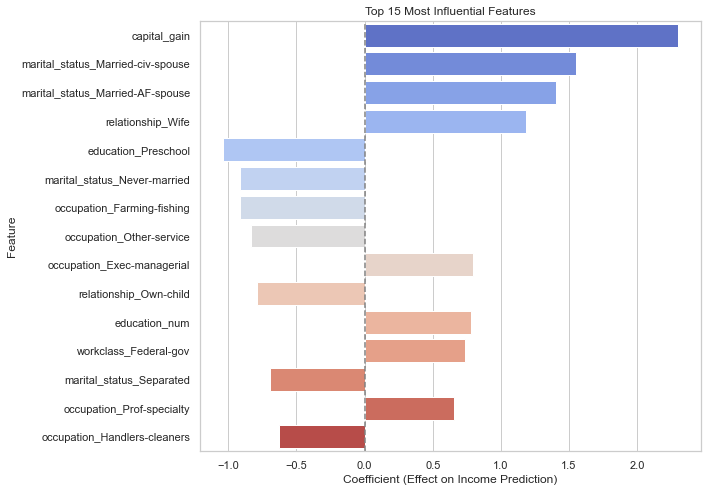

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort features by absolute coefficient value
top_features = feature_importance.copy()
top_features['abs_coeff'] = top_features['Coefficient'].abs()
top_features = top_features.sort_values(by='abs_coeff', ascending=False).head(15)

# Plot
plt.figure(figsize=(10, 7))
sns.barplot(data=top_features, x='Coefficient', y='Feature', palette='coolwarm')

plt.title('Top 15 Most Influential Features')
plt.xlabel('Coefficient (Effect on Income Prediction)')
plt.ylabel('Feature')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


#### Observation
##### Most Influential Positive Features (Strongest Positive Effect on Income Prediction

capital_gain: This is by far the most influential positive feature. A higher capital gain strongly predicts a higher income.

marital_status_Married-civ-spouse: Being married to a civilian spouse has a significant positive impact on income prediction.

marital_status_Married-AF-spouse: Similar to the above, being married to an armed forces spouse also has a strong positive effect on income prediction.

relationship_Wife: Being in a "Wife" relationship also shows a notable positive correlation with income.

##### Most Influential Negative Features (Strongest Negative Effect on Income Prediction

occupation_Handlers-cleaners: This occupation category has the strongest negative impact on income prediction, suggesting individuals in these roles tend to have lower predicted incomes.

occupation_Prof-specialty: Surprisingly, "Prof-specialty" has a negative coefficient, although less strong than "Handlers-cleaners." This might indicate that, in this specific model's context, this category is associated with relatively lower income compared to a baseline or other categories.

marital_status_Separated: Being separated is associated with a lower predicted income.

workclass_Federal-gov: Federal government workclass shows a negative effect, albeit relatively small compared to others.

### Tree-based Model

We move to tree based model to gain insights on the non-linear features and also be able to understand the complex parts from the logistic model.

In [39]:
#We begin by train the model on the training set and then evaluate it on the test set.
from sklearn.tree import DecisionTreeClassifier
# we use the same preprocessor as before
dt_pipeline = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(max_depth=4, random_state=42, class_weight='balanced')
)
# Fit the Decision Tree model
dt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'education_num',
                                                   'capital_gain',
                                                   'capital_loss',
                                                   'hours_per_week']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital_status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native_country'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                                        random_state=42))])

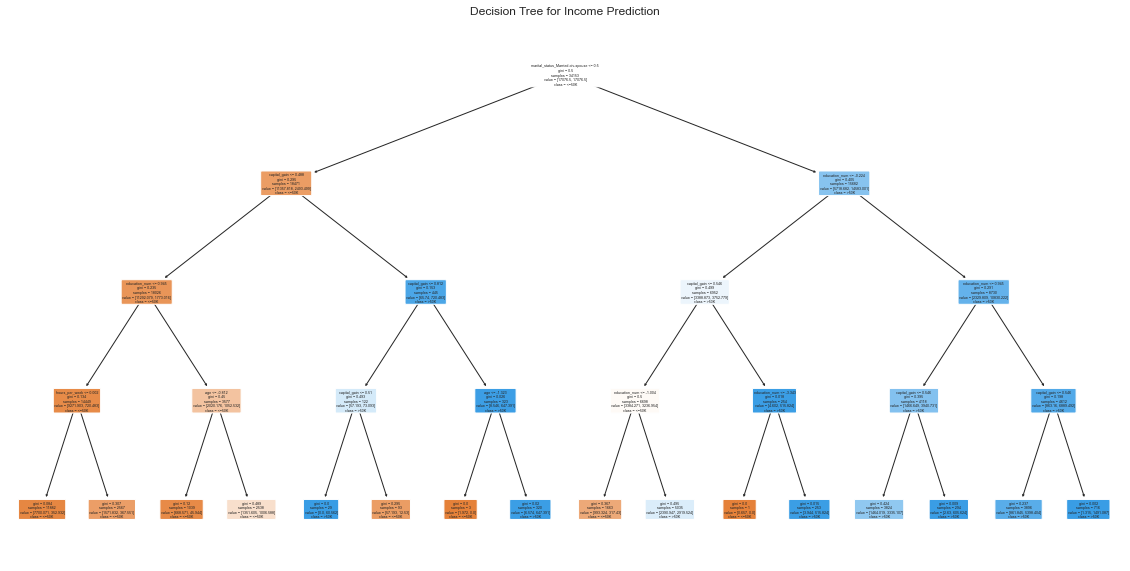

In [40]:
#plotting the Decision Tree
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(dt_pipeline.named_steps['decisiontreeclassifier'],
              feature_names=all_feature_names, 
              class_names=['<=50K', '>50K'], 
              filled=True, 
              rounded=True)
plt.title('Decision Tree for Income Prediction')
plt.show()


In [41]:
#decision tree evaluation
y_pred_dt = dt_pipeline.predict(X_test)
# Calculate accuracy
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Accuracy of the Decision Tree model: {accuracy_dt:.2f}")
# Print classification report
print("Classification Report for Decision Tree:")
print(classification_report(y_test, y_pred_dt))
# Print confusion matrix
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
print("Confusion Matrix for Decision Tree:")
print(conf_matrix_dt)
# Feature importance from Decision Tree
feature_importance_dt = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': dt_pipeline.named_steps['decisiontreeclassifier'].feature_importances_
})
feature_importance_dt = feature_importance_dt.sort_values(by='Importance', ascending=False)
print("Feature Importance from Decision Tree:")
print(feature_importance_dt.head)

Accuracy of the Decision Tree model: 0.76
Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.95      0.72      0.82     11133
           1       0.50      0.87      0.63      3504

    accuracy                           0.76     14637
   macro avg       0.72      0.80      0.73     14637
weighted avg       0.84      0.76      0.78     14637

Confusion Matrix for Decision Tree:
[[8040 3093]
 [ 441 3063]]
Feature Importance from Decision Tree:
<bound method NDFrame.head of                               Feature  Importance
32  marital_status_Married-civ-spouse    0.605119
1                       education_num    0.193552
2                        capital_gain    0.174145
0                                 age    0.018770
4                      hours_per_week    0.008415
..                                ...         ...
29             education_Some-college    0.000000
30            marital_status_Divorced    0.000000
31   mar

#### Observation
The overall accuracy is 76%, which is identical to both the initial Logistic Regression model and the Logistic Regression model after applying SMOTE. This indicates that the Decision Tree, in terms of overall correct predictions, performs similarly.



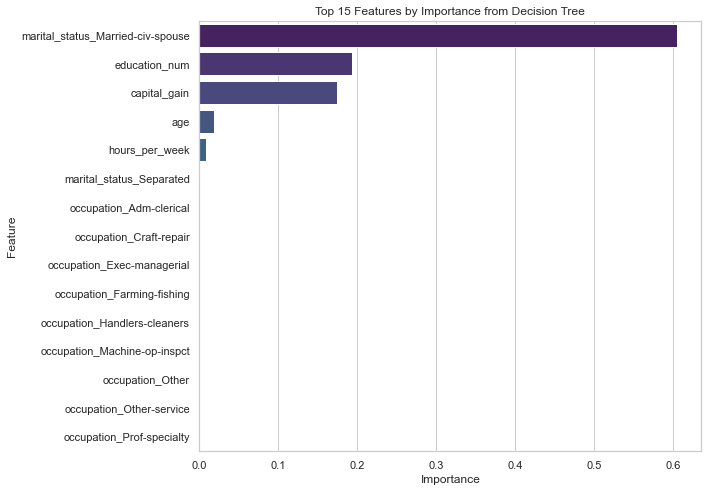

Accuracy of the loaded Decision Tree model: 0.76
Classification Report for Loaded Decision Tree:
              precision    recall  f1-score   support

           0       0.95      0.72      0.82     11133
           1       0.50      0.87      0.63      3504

    accuracy                           0.76     14637
   macro avg       0.72      0.80      0.73     14637
weighted avg       0.84      0.76      0.78     14637

Confusion Matrix for Loaded Decision Tree:
[[8040 3093]
 [ 441 3063]]
Accuracy of the loaded Decision Tree pipeline: 0.76
Classification Report for Loaded Decision Tree Pipeline:
              precision    recall  f1-score   support

           0       0.95      0.72      0.82     11133
           1       0.50      0.87      0.63      3504

    accuracy                           0.76     14637
   macro avg       0.72      0.80      0.73     14637
weighted avg       0.84      0.76      0.78     14637

Confusion Matrix for Loaded Decision Tree Pipeline:
[[8040 3093]
 [ 44

In [42]:
#plotting graph of feature importance from Decision Tree
plt.figure(figsize=(10, 7))
sns.barplot(data=feature_importance_dt.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Features by Importance from Decision Tree')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()
# We can also visualize the Decision Tree using graphviz
from sklearn.tree import export_graphviz
from graphviz import Source
# Export the tree to DOT format
dot_data = export_graphviz(dt_pipeline.named_steps['decisiontreeclassifier'], 
                           out_file=None, 
                           feature_names=all_feature_names, 
                           class_names=['<=50K', '>50K'], 
                           filled=True, 
                           rounded=True)
# Create a graph from the DOT data
graph = Source(dot_data, format='png')
# Render the graph
graph.render('decision_tree_income_prediction', cleanup=True, format='png')
# Display the graph
# Display the graph in Jupyter Notebook
from IPython.display import Image
Image(filename='decision_tree_income_prediction.png')
# Save the model using joblib
import joblib
joblib.dump(dt_pipeline, 'decision_tree_income_prediction_model.pkl')
# Load the model
loaded_model = joblib.load('decision_tree_income_prediction_model.pkl')
# Make predictions with the loaded model
y_pred_loaded = loaded_model.predict(X_test)
# Calculate accuracy of the loaded model
accuracy_loaded = accuracy_score(y_test, y_pred_loaded)
print(f"Accuracy of the loaded Decision Tree model: {accuracy_loaded:.2f}")
# Print classification report for the loaded model
print("Classification Report for Loaded Decision Tree:")
print(classification_report(y_test, y_pred_loaded))
# Print confusion matrix for the loaded model
conf_matrix_loaded = confusion_matrix(y_test, y_pred_loaded)
print("Confusion Matrix for Loaded Decision Tree:")
print(conf_matrix_loaded)
# Save the feature importance DataFrame to a CSV file
feature_importance_dt.to_csv('decision_tree_feature_importance.csv', index=False)
# Save the model pipeline to a file
joblib.dump(dt_pipeline, 'decision_tree_pipeline.pkl')
# Load the saved model pipeline
loaded_pipeline = joblib.load('decision_tree_pipeline.pkl')
# Make predictions with the loaded pipeline
y_pred_loaded_pipeline = loaded_pipeline.predict(X_test)
# Calculate accuracy of the loaded pipeline
accuracy_loaded_pipeline = accuracy_score(y_test, y_pred_loaded_pipeline)
print(f"Accuracy of the loaded Decision Tree pipeline: {accuracy_loaded_pipeline:.2f}")
# Print classification report for the loaded pipeline
print("Classification Report for Loaded Decision Tree Pipeline:")
print(classification_report(y_test, y_pred_loaded_pipeline))
# Print confusion matrix for the loaded pipeline
conf_matrix_loaded_pipeline = confusion_matrix(y_test, y_pred_loaded_pipeline)
print("Confusion Matrix for Loaded Decision Tree Pipeline:")
print(conf_matrix_loaded_pipeline)



In summary, this code provides a comprehensive workflow for our decision tree model.

It helps in ;

1) Extracting and visualizing feature importance from a Decision Tree.
2) Creating a visual representation of the Decision Tree model.
3) Saving and loading the trained machine learning pipeline.
4) Evaluating the performance of the loaded model/pipeline on a test set.

From the Graph of features of decision tree we observe *marirtal_status_Married-civ-spouse* as the dominant feature in our model. it is a positive contributer to earning higher income.
it is also followed closely with *education_num* / education_level with has 

### Random Forest Model

In [43]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
#used the same preprocessor as before
rf_pipeline = make_pipeline(
    preprocessor,
    rf
)
# Fit the Random Forest model
rf_pipeline.fit(X_train, y_train)
# Make predictions on the test set
y_pred_rf = rf_pipeline.predict(X_test)




In [44]:
#evaluate the Random Forest modelfrom sklearn.metrics import accuracy_score, classification_report, confusion_matrix
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy of the Random Forest model: {accuracy_rf:.2f}")
# Print classification report
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))
# Print confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

Accuracy of the Random Forest model: 0.84
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90     11133
           1       0.67      0.64      0.66      3504

    accuracy                           0.84     14637
   macro avg       0.78      0.77      0.78     14637
weighted avg       0.84      0.84      0.84     14637



Feature Importance for Random Forest:
                              Feature  Importance
0                                 age    0.227538
4                      hours_per_week    0.109541
32  marital_status_Married-civ-spouse    0.087727
2                        capital_gain    0.076230
1                       education_num    0.070340
..                                ...         ...
31   marital_status_Married-AF-spouse    0.000286
17                  education_1st-4th    0.000239
13              workclass_Without-pay    0.000124
27                education_Preschool    0.000072
7              workclass_Never-worked    0.000004

[65 rows x 2 columns]


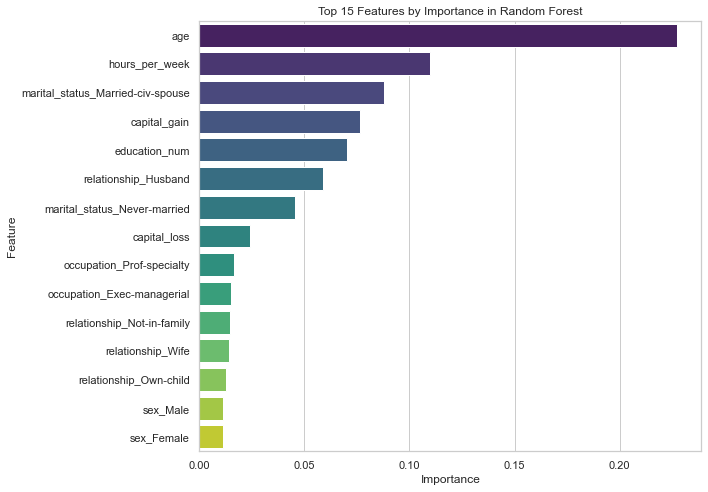

In [45]:
#feature importance for Random Forest
importances = rf_pipeline.named_steps['randomforestclassifier'].feature_importances_
feature_importance_rf = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print("Feature Importance for Random Forest:")
print(feature_importance_rf)
# Plotting feature importance for Random Forest
plt.figure(figsize=(10, 7))
sns.barplot(data=feature_importance_rf.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Features by Importance in Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


This output displays the Feature Importance values for a Random Forest model. As discussed, Random Forests are ensemble models that build many decision trees and average their predictions. Feature importance in Random Forests is typically calculated by averaging the reduction in impurity (like Gini impurity or entropy) contributed by each feature across all the trees in the forest


#### Key Findings on Feature Influence (Across Models):

Top Positive Drivers for >50K Income: capital_gain, marital_status_Married-civ-spouse, education_num, age, and hours_per_week. These consistently show strong positive correlation with higher income.
Strong Negative Driver for >50K Income: education_Preschool.
Varying Model Interpretations:
#### Logistic Regression: 
Quantifies linear effect (e.g., capital_gain has highest positive coefficient).
#### Decision Tree:
 Emphasizes single, dominant splits (marital_status_Married-civ-spouse as most important).
#### Random Forest:
 Provides a more robust feature hierarchy, highlighting age and hours_per_week as overall most important.

#### Model Performance Summary:

#### Overall Accuracy
 Consistent at 76% across all models (Logistic Regression, Logistic Regression with SMOTE, Decision Tree).
#### Logistic Regression (without/with SMOTE):
Good precision for <=50K (90%).
Struggles with >50K precision (around 50%) but has decent recall (72%). SMOTE had minimal impact.
#### Decision Tree:
Excellent recall for >50K (87%) – very good at finding high-income individuals.
Lower precision for >50K (50%) and lower recall for <=50K (72%), indicating more false positives for the >50K class.
Better F1-score for >50K (0.63 vs. 0.59).

Income Variation Across Subgroups:

Strongly Evident: Income varies significantly by marital status (married individuals generally higher income), education level (higher education → higher income; preschool → lower income), and occupation (e.g., managerial → higher income; handlers/cleaners → lower income).

Limited/Indirect Insight: gender, race, and native_country (beyond explicit individual country features not shown as top drivers) showed low importance in models, but this does not negate real-world disparities. Further dedicated analysis is needed for these.


#### Further Observations
This Random Forest feature importance list provides a more robust and balanced view of feature importance compared to a single Decision Tree:

- Shift in Top Features: Unlike the single Decision Tree dominated by marital_status_Married-civ-spouse, the Random Forest prioritizes age and hours_per_week at the very top. 
This suggests that for an ensemble, these continuous features are consistently more useful across diverse trees.

- Distribution of Importance: The importance values are more evenly distributed among the top 5-10 features in the Random Forest compared to the very steep drop-off seen in the single Decision Tree. 
This is typical of Random Forests, which reduce variance and provide a more generalized importance estimate.

- Features with Zero Importance: In contrast to the single Decision Tree where many features had exactly 0 importance, the Random Forest (unless the feature is truly never split on by any tree, or very few instances fall into its category) tends to assign at least a tiny bit of importance to almost all features, reflecting their collective contribution. However, workclass_Never-worked is an outlier with near zero.

The Random Forest provides a comprehensive assessment of feature relevance, highlighting the consistent importance of *age*, *hours_per_week*, *marital_status_Married-civ-spouse*, *capital_gain*, and *education_num* as the primary drivers of income prediction in this dataset.

### Models Alignment with our Objectives
For our first objective we can see all the three models use the features to make predictions. Logistic Regression quantifies linear impact, while Decision Tree and Random Forest quantify importance based on how they split the data to reduce uncertainty, capturing non-linearities and interactions. The specific top predictors vary slightly depending on the model's underlying mechanism.


In our second objective  all outputs highlight *capital_gain*, *education_num*, *age*, *hours_per_week*, and *marital_status_Married-civ-spouse* as strong drivers of the >50K outcome. 

The specific ranking and the type of quantification (linear coefficient vs. impurity reduction importance) differ by model. The Logistic Regression provides the most direct "effect" quantification (how much a unit change increases/decreases odds), while tree-based models show overall "predictive power."


The third objective for Overall Alignment for Subgroups: The outputs provide strong evidence for how marital status, education level, and specific occupations correlate with income. They offer limited or indirect insight into gender, and no direct insight into race or most native countries, highlighting the need for further, dedicated subgroup analysis beyond general model feature importance.




#### Recommendations:

1) Prioritize Random Forest: For overall accuracy and robust understanding of feature importance, further develop and tune the Random Forest model.

2) Refine Imbalance Handling: Explore class_weight parameters or other imblearn techniques within ensemble models, and consider threshold tuning if minority class recall is critical.

3) Conduct Deeper Subgroup Analysis: Perform direct statistical analysis (e.g., mean income by group) and use tools like SHAP values to fully understand income disparities related to gender, race, and all native countries.